### Identify Blood Cell Subtype from Image
- Eosinophil vs Lymphocyte vs Monocyte vs Neutrophil
- Mononuclear (Lymphocyte + Monocyte) vs Polynuclear (Neutrophil + Eosinophil)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [2]:
torch.cuda.is_available()

True

In [3]:
!pwd

/home/nbuser/BloodCell


In [4]:
torch.backends.cudnn.enabled

True

In [5]:
PATH = './dataset2-master/images/'
sz = 224
# arch = resnext101_64
bs = 64
!ls {PATH}

test  TEST_SIMPLE  tmp	train  valid


In [6]:
os.listdir(f'{PATH}valid')

['NEUTROPHIL', 'EOSINOPHIL', 'MONOCYTE', 'LYMPHOCYTE']

In [7]:
files = os.listdir(f'{PATH}valid/MONOCYTE')[:5]
files

['_3_6966.jpeg',
 '_2_5016.jpeg',
 '_1_3280.jpeg',
 '_2_2901.jpeg',
 '_2_4602.jpeg']

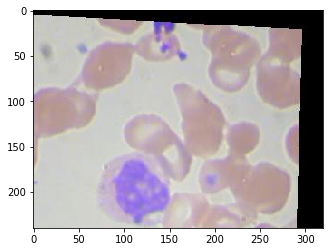

In [8]:
img = plt.imread(f'{PATH}valid/MONOCYTE/{files[1]}')
plt.imshow(img);

In [9]:
img.shape

(240, 320, 3)

In [10]:
os.makedirs('/cache/tmp', exist_ok=True)
!ln -fs /cache/tmp {PATH}

In [11]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

100%|██████████| 39/39 [00:14<00:00,  2.70it/s]


epoch      trn_loss   val_loss   accuracy                   
    0      1.100297   1.187592   0.485726  
    1      0.91675    1.221336   0.496582                    
    2      0.845562   1.202881   0.490953                    



[array([1.20288]), 0.4909529552960137]

In [12]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [13]:
lrf=learn.lr_find()

 85%|████████▍ | 132/156 [00:02<00:00, 46.10it/s, loss=6.27]


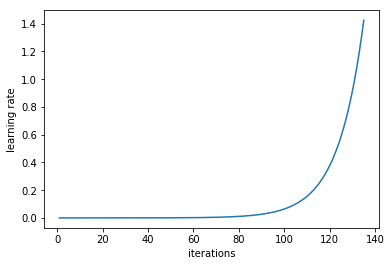

In [14]:
learn.sched.plot_lr()

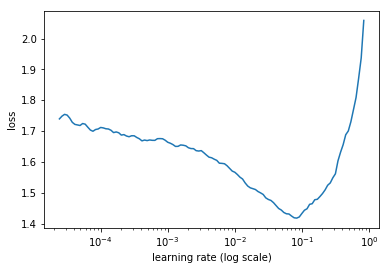

In [15]:
learn.sched.plot()

In [16]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [17]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [18]:
ims = np.stack([get_augs() for i in range(6)])

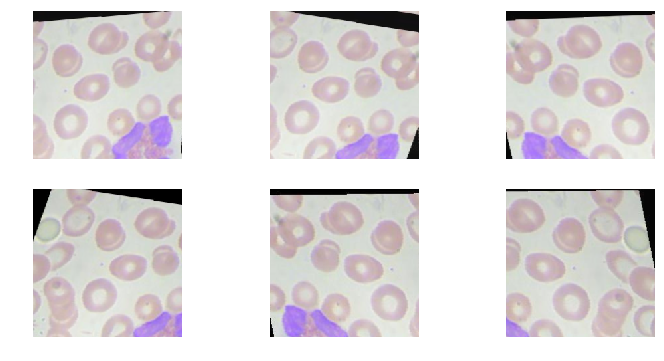

In [19]:
plots(ims, rows=2)

In [20]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [21]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.101087   1.16902    0.488943  



[array([1.16902]), 0.48894250136472445]

In [22]:
learn.precompute=False

In [23]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.982168   1.143952   0.512264  
    1      0.953923   1.147559   0.51548                     
    2      0.916938   1.18915    0.498191                    



[array([1.18915]), 0.49819059100168317]

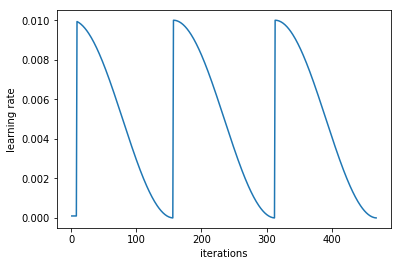

In [24]:
learn.sched.plot_lr()

In [25]:
learn.unfreeze()

In [26]:
lr=np.array([1e-4,1e-3,1e-2])

In [27]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.299375   0.360778   0.862083  
    1      0.129183   0.4119     0.876558                    
    2      0.076648   0.445568   0.873743                     
    3      0.049847   0.447851   0.87696                      
    4      0.036452   0.498545   0.878971                     
    5      0.026357   0.505883   0.87696                      
    6      0.019938   0.581038   0.866506                     



[array([0.58104]), 0.866505829982121]

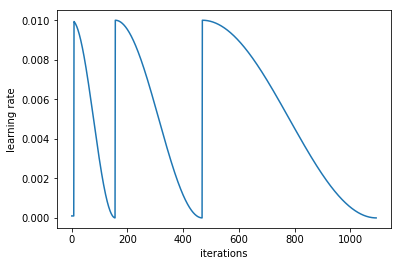

In [28]:
learn.sched.plot_lr()

In [29]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [30]:
accuracy_np(probs, y)

0.8697225572979493

In [31]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[484   5   0 134]
 [  0 620   0   0]
 [  0   0 469 151]
 [ 34   0   0 590]]


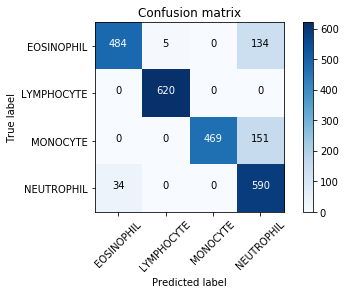

In [33]:
plot_confusion_matrix(cm, data.classes)